In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

# import lnPi.old
import lnpy
import lnpy.stability
from lnpy.lnpicollectionutils import limited_collection


# function to tag 'LD' and 'HD' phases
def tag_phases2(x):
    if len(x) > 2:
        msg = "bad tag function"
        raise ValueError(msg)
    argmax0 = np.array([xx.local_argmax()[0] for xx in x])
    return np.where(argmax0 <= x[0].shape[0] / 2, 0, 1)

# Bulk (easy case)

In [5]:
pe = pd.read_csv(
    "./PiofN/ljsf.t070.bulk.v729.r1.energy.dat",
    header=None,
    sep="\\s+",
    names=["n", "e"],
)["e"].values

mu = -8.616
volume = 729
temp = 0.7
beta = 1.0 / temp
state_kws = {"volume": volume, "temp": temp, "beta": 1 / temp}
lnz = beta * mu

# reference masked lnPi
ref = (
    lnpy.lnPiMasked.from_table(
        "./PiofN/ljsf.t070.bulk.v729.r1.lnpi.dat",
        fill_value=np.nan,
        lnz=lnz,
        state_kws=state_kws,
        extra_kws={"PE": pe},
    )
    .zeromax()
    .pad()
)

# Phase Creator
PhaseCreator = lnpy.segment.PhaseCreator(
    nmax=2, tag_phases=tag_phases2, nmax_peak=4, merge_kws={"efac": 0.8}, ref=ref
)
build_phases = PhaseCreator.build_phases_mu([None])

In [9]:
# create collection
o_course, o = limited_collection(
    build_phases,
    0.5,
    offsets=[-10, +10],
    edge_distance_min=8,
    even_grid=True,
    digits=1,
    limit_course=True,
)

# calc stability
o_course.spinodal(2, build_phases)
o_course.binodal(2, build_phases)

In [12]:
# add to main object
o = o.stability_append(o_course, copy_stability=False)

In [13]:
(
    o_course.binodal.access.xge.table(
        ["pressure", "dens_tot", "PE_n"], default_keys=[], dim_to_suffix="phase"
    )
    .to_dataframe()
    .reset_index()
    .assign(mu=lambda x: x["lnz_0"] / x["beta"])
)

,binodal,lnz_0,phase,volume,temp,beta,pressure_0,pressure_1,dens_tot_0,dens_tot_1,PE_n_0,PE_n_1,mu
0,0,-12.339048,0,729,0.7,1.428571,0.002377,0.002377,0.003509,0.820218,-0.040952,-5.578011,-8.637334
1,0,-12.339048,1,729,0.7,1.428571,0.002377,0.002377,0.003509,0.820218,-0.040952,-5.578011,-8.637334


In [14]:
pd.read_csv("./PiofN/ljsf.t070.bulk.v729.r1.sat.dat", sep="\\s+")

,mu*,p(1)*,p(2)*,rho(1)*,rho(2)*,u(1)*,u(2)*
0,-8.637334,0.002377,0.002377,0.003509,0.820218,-0.040952,-5.578011
1,-4.001997,0.002377,0.002377,0.003509,0.820218,-0.040952,-5.578011


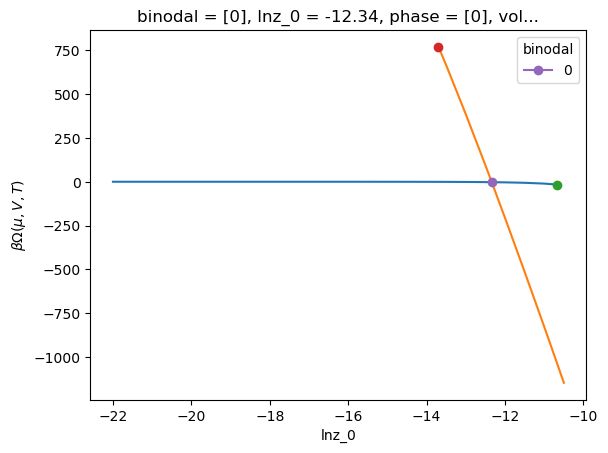

In [17]:
o.xge.betaOmega().plot(hue="phase")

(
    o_course.spinodal.access.xge.betaOmega()
    .unstack()
    .pipe(lambda x: x.where(x.phase == x.spinodal, drop=True))
    .max("phase")
    .plot(hue="spinodal", marker="o")
)

(
    o_course.binodal.access.xge.betaOmega()
    .pipe(lambda x: x.sel(phase=x.binodal))
    .plot.line(hue="binodal", marker="o")
)

# Bulk (hard case)

In [18]:
beta = 1.0 / 0.65

ref_bulk = lnpy.lnPiMasked.from_table(
    "./PiofN/ljcut.t065.bulk.v1000.r1.lnpi.dat",
    lnz=-4.453015418106743e00 / 0.65,
    state_kws={"volume": 1000.0e0, "beta": 1.0 / 0.65000e0},
)

phase_creator_bulk = lnpy.segment.PhaseCreator(
    nmax=2, nmax_peak=4, ref=ref_bulk, merge_kws={"efac": 0.5}, tag_phases=tag_phases2
)
build_phases_bulk = phase_creator_bulk.build_phases_mu([None])

c_course_bulk, c_bulk = limited_collection(
    build_phases_bulk,
    offsets=[-10, +10],
    dlnz=1.0,
    digits=0,
    edge_distance_min=8,
    limit_course=True,
)

c_course_bulk.spinodal(2, build_phases_bulk, inplace=True)
c_course_bulk.binodal(2, build_phases_bulk, inplace=True)

In [23]:
c_bulk = c_bulk.stability_append(c_course_bulk, copy_stability=False)

In [24]:
(
    c_course_bulk.binodal.access.xge.table(
        ["pressure", "dens_tot", "PE_n"], default_keys=[], dim_to_suffix="phase"
    )
    .to_dataframe()
    .reset_index()
    .assign(mu=lambda x: x["lnz_0"] / x["beta"])
)

,binodal,lnz_0,phase,volume,beta,pressure_0,pressure_1,dens_tot_0,dens_tot_1,mu
0,0,-6.851886,0,1000.0,1.538462,0.000696,0.000696,0.001083,0.860734,-4.453726
1,0,-6.851886,1,1000.0,1.538462,0.000696,0.000696,0.001083,0.860734,-4.453726


In [25]:
pd.read_csv("PiofN/ljcut.t065.bulk.v1000.r1.sat.dat", sep="\\s+")

,mu*,p(1)*,p(2)*,rho(1)*,rho(2)*,u(1)*,u(2)*
0,-8.685711,0.000696,0.000696,0.001083,0.860734,-0.014084,-6.214363
1,-4.453724,0.000696,0.000696,0.001083,0.860734,-0.014084,-6.214363


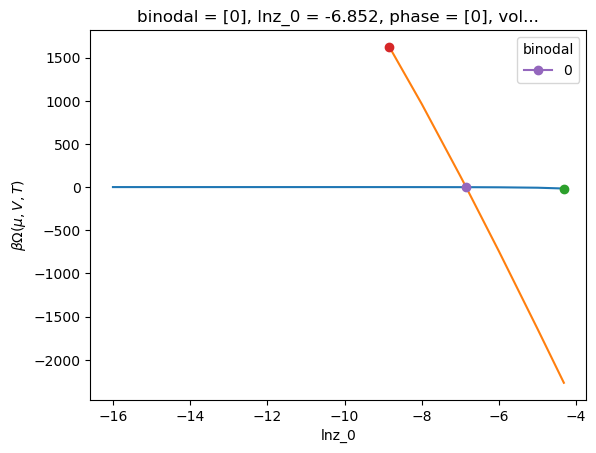

In [26]:
c_bulk.xge.betaOmega().plot(hue="phase")

(
    c_course_bulk.spinodal.access.xge.betaOmega()
    .pipe(lambda x: x.sel(phase=x.spinodal))
    .plot(hue="spinodal", marker="o")
)

(
    c_course_bulk.binodal.access.xge.betaOmega()
    .pipe(lambda x: x.sel(phase=x.binodal))
    .plot.line(hue="binodal", marker="o")
)

# confined

In [27]:
ref_conf = lnpy.lnPiMasked.from_table(
    "./PiofN/ljcut.t065.finiteslit.L_20nm.W_4nm.r2.lnpi.dat",
    lnz=-0.500000e01 / 0.65,
    state_kws={"volume": 7000.0, "beta": 1.0 / 0.65000e0},
)


phase_creator_conf = lnpy.segment.PhaseCreator(
    nmax=2, nmax_peak=4, ref=ref_conf, merge_kws={"efac": 0.6}, tag_phases=tag_phases2
)

build_phases_conf = phase_creator_conf.build_phases_mu([None])

In [28]:
# saturation
# limit to saturation
lnz_max = c_course_bulk.binodal.access.iloc[0].lnz[build_phases_bulk.index]
lnz_range = [-20, lnz_max]

c_course_conf, c_conf = limited_collection(
    build_phases_conf,
    lnz_range=lnz_range,
    dlnz=0.01,
    digits=2,
    edge_distance_min=8,
    limit_course=True,
)

# stability
c_course_conf.spinodal(2, build_phases_conf, inplace=True)
c_course_conf.binodal(2, build_phases_conf, inplace=True)

# add spin/bin to c_conf
c_conf = c_conf.stability_append(c_course_conf)

build:   0%|          | 0/1315 [00:00<?, ?it/s]

AttributeError: can't set attribute

In [34]:
c_conf._cache["spinodal"] = "hello"

In [35]:
c_conf.spinodal

'hello'

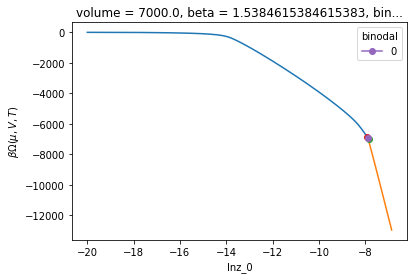

In [24]:
c_conf.xge.betaOmega().plot(hue="phase")

(
    c_conf.spinodal.access.xge.betaOmega()
    .pipe(lambda x: x.sel(spinodal=x.phase))
    .plot(hue="phase", marker="o")
)

(
    c_conf.binodal.access.xge.betaOmega()
    .pipe(lambda x: x.sel(phase=x.binodal))
    .plot.line(hue="binodal", marker="o")
)

# make isotherm

In [25]:
# comparison data
df = pd.read_table(
    "./PiofN/ljcut.t065.finiteslit.L_20nm.W_4nm.r2.single_isotherm.txt",
    sep="\\s+",
    header=None,
    names=["pscaled", "mu", "rho", "Omega_L", "Qst", "Gads"],
)

In [26]:
# rebuild on same spacing as conf
c_bulk_ = lnPi.CollectionlnPi.from_builder(
    c_conf.get_index_level("lnz_0"), build_phases_bulk
)

In [27]:
psat = c_course_bulk.binodal.access.xge.pressure().sel(phase=0).squeeze().values

In [32]:
table_bulk = (
    c_bulk_.xge.table(["pressure"], ref=ref_bulk, mask_stable=True)
    .assign(pscaled=lambda x: x.pressure / psat)
    .drop(["volume"])
)

table_conf = c_conf.xge.table(["ntot"], ref=ref_conf).drop("volume")

isotherm = xr.merge((table_bulk.pscaled, table_conf.ntot), join="inner").set_coords(
    "pscaled"
)

In [31]:
# check distances
print(table_bulk.edge_distance.min())
print(table_conf.edge_distance.min())

<xarray.DataArray 'edge_distance' ()>
array(920.)
Coordinates:
    beta     float64 1.538
<xarray.DataArray 'edge_distance' ()>
array(286.)
Coordinates:
    beta     float64 1.538


In [33]:
# spinodal lnzs
lnz_spin = c_conf.spinodal.access.get_index_level("lnz_0")

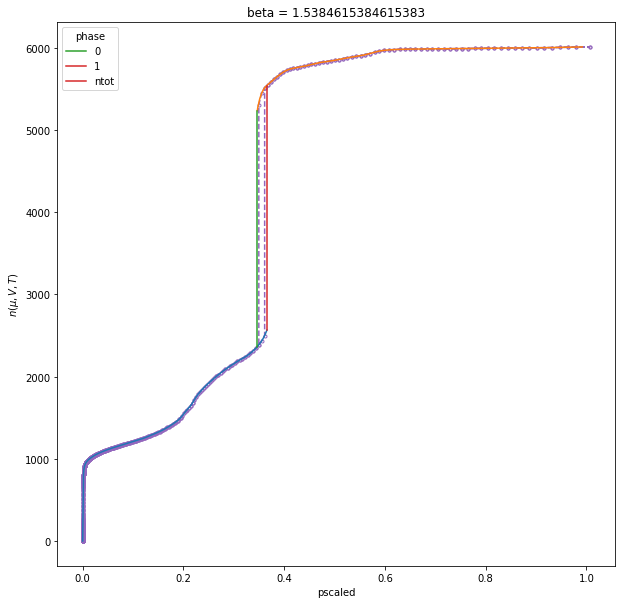

In [37]:
fig, ax = plt.subplots(figsize=(10, 10))
(isotherm.ntot.swap_dims({"lnz_0": "pscaled"}).plot(hue="phase"))

for _meta, g in (
    isotherm.sel(lnz_0=lnz_spin).to_dataframe().reset_index().groupby("lnz_0")
):
    g.plot("pscaled", "ntot", ax=plt.gca())

plt.plot(df.pscaled, df.rho, marker="o", mfc="None", ls="--", zorder=-1, ms=3)
# plt.xlim(0.3, 0.45)
# plt.ylim(5000, 6000)